# Snorkel LinTo 

### Contents
#### 1. Data loading
#### 2. Label definition
#### 3. Train/test/dev sets separation
#### 4. Rules writing
#### 5. Application of the rules
#### 6. Generative model
#### 7. Analysis of the results
#### 8. Useful files creation


## 1. Data loading

In [22]:
%matplotlib inline
import os
import numpy as np

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"


In [23]:
import pandas as pd


DISPLAY_ALL_TEXT = True

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)



In [24]:

import spacy

nlp = spacy.load('fr_core_news_sm')

# if not loaded : french model
#! python -m spacy download fr_core_news_sm

In [25]:
# Complete dataframe loading with columns : 
#      'word', 'beg_word', 'end_word', 'n_round',
#       'beg_round', 'end_round', 'rank_round', 'text_round', 'sil_bef',
#       'sil_aft', 'tony', 'gold', 'prob_nothing', 'prob_point', 'prob_comma',
#       'prob_nothing_bef', 'prob_point_bef', 'prob_comma_bef',
#       'real_rank_round', 'pitch', 'energy', 'pitch_bef', 'energy_bef',
#       'punct', 'punct_bef', 'file', 'tony_realturns', 'token', 'token_bef',
#      'token_aft', 'dep', 'dep_bef', 'dep_aft', 'headpos', 'headpos_bef',
#      'headpos_aft', 'energy_aft', 'pitch_aft'

df_linto = pd.read_csv("../data/df_all_final_LinTo_17032021.csv")
df_linto.head()

,word,beg_word,end_word,n_turn,beg_turn,end_turn,rank_turn,text_turn,sil_bef,sil_aft,...,token_bef,token_aft,dep,dep_bef,dep_aft,headpos,headpos_bef,headpos_aft,energy_aft,pitch_aft
0,ok,2.00,2.37,0,0.0,10.123,0,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,1.26,0.00,...,ADP,ADV,ROOT,ROOT,advmod,ADP,ADP,ADP,0,0
1,donc,2.73,3.01,0,0.0,10.123,1,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,0.24,...,ADP,ADV,advmod,ROOT,advmod,ADP,ADP,VERB,D,U
2,juste,3.38,3.67,0,0.0,10.123,2,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.24,0.00,...,ADV,SCONJ,advmod,advmod,mark,VERB,ADP,VERB,D,D
3,comme,3.92,4.22,0,0.0,10.123,3,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,0.00,...,ADV,PRON,mark,advmod,nsubj,VERB,VERB,VERB,U,D
4,on,4.23,4.67,0,0.0,10.123,4,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,0.12,...,SCONJ,VERB,nsubj,mark,xcomp,VERB,VERB,ADP,D,U


In [26]:
# to-do : check if every columns are presents in the loaded file

## 2. Label definition

In [27]:
ABSTAIN = -1
NO = 0
BOS = 1

## 3. Train/test/dev sets separation

In [28]:
df_dev = df_linto[(df_linto["file"]=="Linagora_R1") | (df_linto["file"]=="Linagora_A1")]
df_test = df_linto[(df_linto["file"]=="Linagora_P1") | (df_linto["file"]=="Linagora_C1")]
df_train=df_linto[(df_linto["file"]!="Linagora_R1")&(df_linto["file"]!="Linagora_A1")&(df_linto["file"]!="Linagora_P1")&(df_linto["file"]!="Linagora_C1")]


Y_test = df_test["gold"].values
Y_dev = df_dev["gold"].values

print("dev length = ", len(df_dev),"words \ntest length = ", len(df_test),"words \ntrain length = ", len(df_train), "words")

dev length =  9752 words 
test length =  8833 words 
train length =  53692 words


## 4. Rules writing

### Basic rules (without preprocessor)



In [29]:
from snorkel.labeling import labeling_function


# If ToNy (written) predicts BOS -> BOS
@labeling_function()
def tony(x):
    return BOS if x["tony"]==1 else ABSTAIN

#  If beginning of turn -> BOS 
@labeling_function()
def beg_turn(x):
    return BOS if x["rank_turn"]==0 else ABSTAIN

# If period likelihood just before the current word > 0.3 -> BOS 
@labeling_function()
def period_bef(x):
    return BOS if x["prob_period_bef"]>0.3 and x["word"]!="euh" else ABSTAIN

# If no punctuation likelihood after the current word > 0.99 -> NO
@labeling_function()
def nothing_bef(x):
    return NO if x["prob_nothing_bef"]>0.99 else ABSTAIN

# If comma likelihood just before the current word > 0.3 -> BOS
@labeling_function()
def comma_bef(x):
     return BOS if x["prob_comma_bef"]>0.3 else ABSTAIN


# If repetitions/hesitations ("euh" aside) -> NO
@labeling_function()
def no_disfluency(x):
    param_context=4
    list_text=str(x["text_turn"]).split(" ")
    pos=int(x["rank_turn"])
    context=[]
    cmpt=0
    if pos>param_context and pos<len(list_text)-param_context:
        for e in list_text[pos-param_context:pos+param_context]:
            context.append(e)
        while "euh" in context:
            context.remove("euh")
            cmpt+=1
        if abs(len(set(context))-len(context))>=2 or cmpt>2:
            return NO
        
    param_context=2
    context=[]
    cmpt=0
    if pos>param_context and pos<len(list_text)-param_context:
        for e in list_text[pos-param_context:pos+param_context]:
            context.append(e)
        if len(set(context))!=len(context):
            return NO
    return ABSTAIN

# If energy and pitch follow a particular pattern -> BOS
@labeling_function()
def energy_pitch(x):
    liste_features=["DUUS", "DDUS", "DDUU", "SDUD", "SUUD", "SUUU"]
    str_feat=str(x.energy_bef)+str(x.energy)+str(x.pitch_bef)+str(x.pitch)
    
    if str_feat in liste_features and x.word!="euh" and x.sil_bef>0.3:
        return BOS

    return ABSTAIN


@labeling_function()
def energy_pitch2(x):
    if x.sil_bef>0.3:
        if (x.energy_bef=="D" and x.pitch_bef=="U") and x.word!="euh":
            return BOS
    return ABSTAIN



# If word belongs to a specific type -> BOS 
@labeling_function()
def cc(x):
    notype=["ADJ", "DET", "AUX", "VERB"]
    if x.i_token in liste_begcc :#and x.token not in notype:
        return BOS
    return ABSTAIN



liste_tok=["CCONJ"]
liste_tok_bef=["NOUN"]
liste_tok_dep=["nsubj", "cc", "advmod", "nmod", "amod", "expl:subj", "obj", "dep"]

 
@labeling_function()
def pos(x):
    if x.token in liste_tok and x.token_bef!="CCONJ" and x.token_aft!="NOUN" and x.prob_comma_bef>0.05:
        return BOS
    return ABSTAIN

# If previous, current and next word belongs to specific types -> BOS 
@labeling_function()
def cconj(x):
    liste_no=["euh", "pas", "que", "ou", "tu", "aussi", "là"]
    if (x.token_bef=="NOUN" and  x.token=="CCONJ" and x.token_aft=="PRON") or (x.token_bef=="NOUN" and  x.token=="SCONJ" and x.token_aft=="SCONJ") or (x.token_bef=="NOUN" and  x.token=="ADV" and x.token_aft=="PRON") and x.word not in liste_no:
        return BOS
    return ABSTAIN


# Si le modèle de samir met un period avant le mot -> BOS
@labeling_function()
def punct_samir_period(x):
    if x.punct_bef=="." and x.word!="euh" and x.sil_bef>0:
        return BOS
    return ABSTAIN 

# Si le modèle de samir met une virgule avant le mot -> BOS
@labeling_function()
def punct_samir_comma(x):
    if x.punct_bef=="," and x.word!="euh" and x.sil_bef>0:
        return BOS
    return ABSTAIN 

# Si le mot d'avant est un NOUN et l'énergie avant est descendante (D) -> BOS
@labeling_function()
def noun_d(x):
    liste_tok=["PRON", "ADV", "CCONJ"]
    if x.token_bef=="NOUN" and x.energy_bef=="D" and x.token in liste_tok and x.energy!="D":
        return BOS
    return ABSTAIN


# Si début de vrai tour -> BOS
@labeling_function()
def beg_real_turn(x):
    if x.real_rank_turn==0:
        return BOS
    return ABSTAIN


### Rules using preprocessor

#### Preprocessor creation

In [30]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="word",language='fr_core_news_sm', doc_field="doc", memoize=True)


In [31]:
import numpy as np
from snorkel.preprocess import preprocessor

# give access to the left and right word of the current word.

@preprocessor(memoize=True)
def word_context_markers(x):
    list_text=str(x["text_turn"]).split(" ")
    pos=int(x["rank_turn"])
    if pos<len(list_text)-1 and pos>0:
        x.word_bef = list_text[pos-1]
        x.word_aft = list_text[pos+1]
    elif pos==0 and pos<len(list_text)-1:
        x.word_bef = np.nan
        x.word_aft= list_text[pos+1]
    elif pos==len(list_text)-1 and pos==0:
        x.word_aft = np.nan
        x.word_bef = list_text[pos-1]
    else:
        x.word_aft = np.nan
        x.word_bef = np.nan
    #return x


# set the atrribut x.marker to 1 if the word is a isolated discursive marker, or the first of a list of markers
    couples_markers=dict(du=["coup"], de=["fait"], en=["fait", "vrai", "effet"], parce=["que","qu'"], et=["puis", "donc"],enfin=["bon"],mais=["bon"], à=["propos"], tu=["vois","sais"])
    single_markers=["ouais", "donc","effectivement","alors","bref","voilà", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
    
    list_text=str(x["text_turn"]).split(" ")
    wrd=str(x["word"])
    pos=int(x["rank_turn"])
    
    m=0
    if pos!=len(list_text)-1:
        wrd_aft=str(list_text[pos+1])
        if wrd in single_markers or ((wrd in couples_markers.keys()) and (wrd_aft in couples_markers[wrd])):
            if pos==0:
                m=1
            else:
                wrd_bef=str(list_text[pos-1])
                if wrd_bef in single_markers:
                    m=0
                else:
                    if pos==1:
                        m=1
                    else:
                        wrd_bef_bef=str(list_text[pos-2])
                        if wrd_bef_bef in couples_markers.keys() and wrd_bef in couples_markers[wrd_bef_bef]:
                            m=0
                        else:
                            m=1
    x.marker=m

# set the attribut x.aft_mark to 1 if the word follows a serie of markers or one marker.

    couples_markers=dict(du=["coup"], de=["fait"], en=["fait", "vrai", "effet"], parce=["que","qu'"], et=["puis", "donc"],enfin=["bon"],mais=["bon"], à=["propos"], tu=["vois","sais"])
    single_markers=["ouais", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
    
    list_text=str(x["text_turn"]).split(" ")
    wrd=str(x["word"])
    pos=int(x["rank_turn"])
    bef=0
    aft_mark=0
    if pos>0:
        wrd_bef=str(list_text[pos-1])
        for k in couples_markers.keys():
            if wrd_bef in couples_markers[k]:
                bef=1
        #print(wrd, wrd_bef, bef)
        if wrd_bef in single_markers or bef==1:
            if wrd not in single_markers and wrd not in couples_markers.keys():
                aft_mark=1
            else:
                aft_mark=0
        else:
            aft_mark=0
    
    x.aft_mark=aft_mark
    return x

#### Pre-processor : word_context_markers

In [32]:
# If current word is an isolated marker or ther first of a serie -> BOS
@labeling_function(pre=[word_context_markers])
def first_marker(x):
    if x.marker==1:
        return BOS
    else:
        return ABSTAIN

In [33]:
# If the current word follows an isolated marker or a serie of markers -> NO
@labeling_function(pre=[word_context_markers])
def no_after_markers(x):
    if x.aft_mark==1:
        return NO
    else:
        return ABSTAIN

    
# If energy/f0 follow a specific pattern -> NO
@labeling_function(pre=[word_context_markers])
def no_energy_pitch(x):
    list_nrj_bef=["S", "U"]
    list_pitch_bef=["D", "S"]
    beg_markers=["bonjour", "quand", "par","merci", "ok", "bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils","qui", "que", "j'","c'"]
    if (x.energy_bef in list_nrj_bef and x.pitch_bef in list_pitch_bef)or  (x.energy_bef=="D" and x.energy=="D"):
        if x.marker!=1 and x.word not in pronoms:
            return NO
    return ABSTAIN


#### Pre-processor : spacy

In [34]:
# If word is a specific type -> NO
@labeling_function(pre=[spacy])
def no_type(x):
    """Ham comments mention specific people and are short."""
    if  any([(token.pos_ == "ADJ" or token.pos_ == "DET" or token.pos_ == "AUX" or token.pos_ == "VERB") for token in x.doc]) :
        return NO
    else:
        return ABSTAIN



#### Pre-processor : word_context_markers

In [35]:
# If silence longer than 0.7s before the word -> BOS

@labeling_function(pre=[word_context_markers])
def sil_bef(x):
    
    if x.aft_mark!=1 and x["sil_bef"]>=0.7 and x.word_bef!="euh" and x.word_aft!="euh" and x.word_bef!=x.word_aft and x.word_bef!=x["word"] and x.word_aft!=x["word"] and x["word"]!="euh":
        single_markers=["donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
        pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils"]
        
        return BOS


    return ABSTAIN



# If no silence before the word -> NO
@labeling_function(pre=[word_context_markers])
def no_sil_bef(x):
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils","qui", "que", "j'","c'"]
    if x["sil_bef"]==0 and x["word"]=="en" and x.word_aft=="fait":
            return ABSTAIN
    elif x["sil_bef"]==0 and x.marker!=1 and x["word"] not in pronoms:
        return NO
    else:
        return ABSTAIN

# If word in keyword list -> BOS
@labeling_function(pre=[word_context_markers])
def keywords(x):
    liste=["bonjour", "merci", "ok", "oui", "non", "ouais"]
    if x.aft_mark!=1:
        if x.word in liste or (x.word=="d'" and x.word_aft=="accord") or (x.word=="hum" and x.word_aft=="hum"):
            return BOS 
    return ABSTAIN


# If combination of audio and spacy info are successful in dev set
@labeling_function(pre=[word_context_markers])
def audio_spacy(x):
    
   
    dict_PC_PCe=dict(NOUN_PRON=["DU", "DS", "US"],
                    NOUN_CCONJ=["DD", "DU", "DS", "UD", "UU", "US", "SD", "SU"],
                    NOUN_ADV=["DD"],
                    ADJ_PRON=["DU", "DS"],
                    ADJ_CCONJ=["DD", "DU", "DS", "UU"],
                    NOUN_SCONJ=["DD", "DS"],
                    PROPN_PRON=["DU", "DS", "UD", "UU"],
                    ADV_CCONJ=["DD", "DU", "UD"],
                    VERB_CCONJ=["DD"]
                    )


    dict_PC_PCp=dict(NOUN_PRON=["US", "DK", "UD", "SD", "UK"],
                    NOUN_CCONJ=["SS","DD", "SK","UD", "SD", "KS", "UK"],
                    NOUN_ADV=["UD", "KS", "US", "UU"],
                    ADJ_PRON=["SK", "DK","UD","UK"],
                    ADJ_CCONJ=["SS","DD", "US", "DK", "UD", "SD"],
                    NOUN_SCONJ=["DD","SK", "UK"],
                    ADJ_ADV=["US","UD"],
                    PROPN_PRON=["SS"],
                    ADJ_SCONJ=["SS","DD", "DK", "UD"]
                    )


    dict_PC_PCpe=dict(NOUN_PRON=["DK_DS", "SK_DS", "US_DU", "UK_DS", "UD_DU", "SD_DU", "UK_DU", "DK_DU"],
                    NOUN_CCONJ=["SS_DU", "UD_DU", "SK_DU"],
                    NOUN_ADV=["SS_DD", "UD_DD", "US_DD"]
                     )
    
                      
    PCpos=x.token_bef+"_"+x.token
    PCe=str(x.energy_bef)+str(x.energy)
    PCp=str(x.pitch_bef)+str(x.pitch)
    PCp_PCe=str(x.pitch_bef)+str(x.pitch)+"_"+str(x.energy_bef)+str(x.energy)
                      
    if x.aft_mark!=1:
        if PCpos in dict_PC_PCe.keys() and PCe in dict_PC_PCe[PCpos]:
            return BOS
        if PCpos in dict_PC_PCp.keys() and PCp in dict_PC_PCp[PCpos]:
            return BOS
        if PCpos in dict_PC_PCpe.keys() and PCp_PCe in dict_PC_PCpe[PCpos]:
            return BOS
    return ABSTAIN



@labeling_function(pre=[word_context_markers])
def spacy_pattern(x):
    
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    
    PCpos=x.token_bef+"_"+x.token
    Cdep=x.dep
    Cheadpos=x.headpos
    Pdep=x.dep_bef
    Pheadpos=x.headpos_bef
    
    dict_PC_Cdep=dict(NOUN_PRON=["nsubj", "obj", "nmod"],
                    NOUN_CCONJ=["cc"],
                    NOUN_ADV=["advmod"],
                    NOUN_SCONJ=["mark"],
                    ADJ_ADV=["advmod"],
                    PROPN_PRON=["nsubj"],
                    ADV_CCONJ=["cc"],
                    VERB_CCONJ=["cc"]
                    )


    dict_PC_Cheadpos=dict(NOUN_PRON=["ADJ","PRON","AUX"],
                        NOUN_CCONJ=["VERB","NOUN", "ADJ", "ADV", "PRON"],
                        ADJ_PRON=["VERB"],
                        ADJ_CCONJ=["VERB","NOUN", "ADJ", "ADV"],
                        NOUN_SCONJ=["VERB"],
                        PROPN_PRON=["VERB","NOUN"],
                        ADV_CCONJ=["VERB","NOUN"],
                        VERB_CCONJ=["VERB","NOUN", "ADV"]
                        )



    dict_PC_Pheadpos=dict(NOUN_PRON=["VERB", "ADJ", "PRON"],
                        NOUN_CCONJ=["VERB", "NOUN", "ADJ", "ADV"],
                        ADJ_PRON=["NOUN"],
                        ADJ_CCONJ=["VERB", "NOUN", "ADJ", "ADV"],
                        NOUN_SCONJ=["NOUN"],
                        ADJ_ADV=["NOUN"],
                        PROPN_PRON=["VERB", "NOUN"],
                        ADV_CCONJ=["VERB", "NOUN"],
                        VERB_CCONJ=["VERB"]
                        )

    dict_PC_Pdep=dict(NOUN_PRON=["nomd", "obj", "obl:arg", "dep", "ccomp"],
                    NOUN_CCONJ=["nmod", "obj", "amod", "obj:mod", "obl:arg"],
                    NOUN_ADV=["nmod"],
                    ADJ_PRON=["amod", "xcomp"],
                    VERB_ADV=["nmod", "obj", "dep"],
                    NOUN_SCONJ=["nmod"],
                    ADV_CCONJ=["advmod"], 
                    VERB_CCONJ=["xcomp"]
                        )
    if x.aft_mark!=1:
        if PCpos in dict_PC_Cdep.keys() and Cdep in dict_PC_Cdep[PCpos]:
            return BOS
        if PCpos in dict_PC_Pdep.keys() and Pdep in dict_PC_Pdep[PCpos]:
            return BOS
        if PCpos in dict_PC_Pheadpos.keys() and Pheadpos in dict_PC_Pheadpos[PCpos]:
            return BOS
        if PCpos in dict_PC_Cheadpos.keys() and Cheadpos in dict_PC_Cheadpos[PCpos]:
            return BOS
    return ABSTAIN

@labeling_function(pre=[word_context_markers])
def audio_spacy_spacy(x):
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    
    dict_PC_PCe=dict(NOUN_PRON=["DU", "DS", "US"],
                    NOUN_CCONJ=["DD", "DU", "DS", "UD", "UU", "US", "SD", "SU"],
                    NOUN_ADV=["DD"],
                    ADJ_PRON=["DU", "DS"],
                    ADJ_CCONJ=["DD", "DU", "DS", "UU"],
                    NOUN_SCONJ=["DD", "DS"],
                    PROPN_PRON=["DU", "DS", "UD", "UU"],
                    ADV_CCONJ=["DD", "DU", "UD"],
                    VERB_CCONJ=["DD"]
                    )


    dict_PC_PCp=dict(NOUN_PRON=["US", "DK", "UD", "SD", "UK"],
                    NOUN_CCONJ=["SS","DD", "SK","UD", "SD", "KS", "UK"],
                    NOUN_ADV=["UD", "KS", "US", "UU"],
                    ADJ_PRON=["SK", "DK","UD","UK"],
                    ADJ_CCONJ=["SS","DD", "US", "DK", "UD", "SD"],
                    NOUN_SCONJ=["DD","SK", "UK"],
                    ADJ_ADV=["US","UD"],
                    PROPN_PRON=["SS"],
                    ADJ_SCONJ=["SS","DD", "DK", "UD"]
                    )


    dict_PC_PCpe=dict(NOUN_PRON=["DK_DS", "SK_DS", "US_DU", "UK_DS", "UD_DU", "SD_DU", "UK_DU", "DK_DU"],
                    NOUN_CCONJ=["SS_DU", "UD_DU", "SK_DU"],
                    NOUN_ADV=["SS_DD", "UD_DD", "US_DD"]
                     )
        

    PCpos=x.token_bef+"_"+x.token
    Cdep=x.dep
    Cheadpos=x.headpos
    Pdep=x.dep_bef
    Pheadpos=x.headpos_bef
    
    dict_PC_Cdep=dict(NOUN_PRON=["nsubj", "obj", "nmod"],
                    NOUN_CCONJ=["cc"],
                    NOUN_ADV=["advmod"],
                    NOUN_SCONJ=["mark"],
                    ADJ_ADV=["advmod"],
                    PROPN_PRON=["nsubj"],
                    ADV_CCONJ=["cc"],
                    VERB_CCONJ=["cc"]
                    )


    dict_PC_Cheadpos=dict(NOUN_PRON=["ADJ","PRON","AUX"],
                        NOUN_CCONJ=["VERB","NOUN", "ADJ", "ADV", "PRON"],
                        ADJ_PRON=["VERB"],
                        ADJ_CCONJ=["VERB","NOUN", "ADJ", "ADV"],
                        NOUN_SCONJ=["VERB"],
                        PROPN_PRON=["VERB","NOUN"],
                        ADV_CCONJ=["VERB","NOUN"],
                        VERB_CCONJ=["VERB","NOUN", "ADV"]
                        )



    dict_PC_Pheadpos=dict(NOUN_PRON=["VERB", "ADJ", "PRON"],
                        NOUN_CCONJ=["VERB", "NOUN", "ADJ", "ADV"],
                        ADJ_PRON=["NOUN"],
                        ADJ_CCONJ=["VERB", "NOUN", "ADJ", "ADV"],
                        NOUN_SCONJ=["NOUN"],
                        ADJ_ADV=["NOUN"],
                        PROPN_PRON=["VERB", "NOUN"],
                        ADV_CCONJ=["VERB", "NOUN"],
                        VERB_CCONJ=["VERB"]
                        )

    dict_PC_Pdep=dict(NOUN_PRON=["nomd", "obj", "obl:arg", "dep", "ccomp"],
                    NOUN_CCONJ=["nmod", "obj", "amod", "obj:mod", "obl:arg"],
                    NOUN_ADV=["nmod"],
                    ADJ_PRON=["amod", "xcomp"],
                    VERB_ADV=["nmod", "obj", "dep"],
                    NOUN_SCONJ=["nmod"],
                    ADV_CCONJ=["advmod"], 
                    VERB_CCONJ=["xcomp"]
                     )
    #PCpos=x.token_bef+"_"+x.token
    PCe=str(x.energy_bef)+str(x.energy)
    PCp=str(x.pitch_bef)+str(x.pitch)
    PCp_PCe=str(x.pitch_bef)+str(x.pitch)+"_"+str(x.energy_bef)+str(x.energy)
    cmpt=0             
    if x.aft_mark!=1:
        if PCpos in dict_PC_PCe.keys() and PCe in dict_PC_PCe[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_PCp.keys() and PCp in dict_PC_PCp[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_PCpe.keys() and PCp_PCe in dict_PC_PCpe[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Cdep.keys() and Cdep in dict_PC_Cdep[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Pdep.keys() and Pdep in dict_PC_Pdep[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Pheadpos.keys() and Pheadpos in dict_PC_Pheadpos[PCpos]:
            cmpt+=1
        if PCpos in dict_PC_Cheadpos.keys() and Cheadpos in dict_PC_Cheadpos[PCpos]:
            cmpt+=1
    
        if cmpt>=3:
            return BOS
    
    return ABSTAIN
    


# If ToNy detects a Segment -> Begin of Segment (BOS)
@labeling_function(pre=[word_context_markers])
def tony_realturns(x):
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    if x["tony_realturns"]==1 and x.aft_mark!=1:
        return BOS 
    return ABSTAIN

## 5. Application of the rules on the 3 sets

In [36]:
from snorkel.labeling import PandasLFApplier
# list of rules wanted to annotate the corpus
lfs=[ cconj, tony_realturns, first_marker,  no_type, no_sil_bef, no_after_markers, no_disfluency, period_bef, nothing_bef, keywords,no_energy_pitch, audio_spacy_spacy, audio_spacy, spacy_pattern, beg_real_turn]

#lfs=[ tony_realturns, first_marker,  no_type, no_sil_bef, no_after_markers, no_disfluency, period_bef, nothing_bef, beg_real_turn]

#lfs=[cconj, tony, first_marker, no_sil_bef, no_after_markers, no_disfluency, period_bef, nothing_bef, keywords, pos,cc, energy_pitch, no_energy_pitch, energy_pitch2]

applier = PandasLFApplier(lfs=lfs)
L_dev = applier.apply(df=df_dev)
L_test = applier.apply(df=df_test)
L_train = applier.apply(df=df_train)

100%|██████████| 53692/53692 [04:59<00:00, 179.03it/s]


### Coverage evaluation

In [37]:
coverage = (L_train != ABSTAIN).mean(axis=0)
i=0
for score in list(coverage):
    print(lfs[i], f"coverage: {score * 100:.1f}%")
    i+=1


LabelingFunction cconj, Preprocessors: [] coverage: 0.9%
LabelingFunction tony_realturns, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 10.3%
LabelingFunction first_marker, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 4.5%
LabelingFunction no_type, Preprocessors: [SpacyPreprocessor SpacyPreprocessor, Pre: []] coverage: 34.5%
LabelingFunction no_sil_bef, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 66.5%
LabelingFunction no_after_markers, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 7.9%
LabelingFunction no_disfluency, Preprocessors: [] coverage: 17.5%
LabelingFunction period_bef, Preprocessors: [] coverage: 6.7%
LabelingFunction nothing_bef, Preprocessors: [] coverage: 49.6%
LabelingFunction keywords, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 2.0%
LabelingFunction no_energy_pitch, Preprocessors: [LambdaMapper word_context_markers, Pre: []] coverage: 40.0%
Label

### L_train observation

In [38]:
# train summary 
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
cconj,0,[1],0.009424,0.009405,0.003408
tony_realturns,1,[1],0.103032,0.094092,0.050268
first_marker,2,[1],0.044588,0.038404,0.014416
no_type,3,[0],0.344763,0.338281,0.026671
no_sil_bef,4,[0],0.665071,0.619329,0.059823
no_after_markers,5,[0],0.079248,0.063771,0.004172
no_disfluency,6,[0],0.175147,0.161216,0.030861
period_bef,7,[1],0.066565,0.063566,0.034735
nothing_bef,8,[0],0.495772,0.469753,0.011920
keywords,9,[1],0.019537,0.019407,0.016669


In [39]:
print(LFAnalysis(L=L_train, lfs=lfs).lf_summary())

                    j Polarity  Coverage  Overlaps  Conflicts
cconj              0   [1]      0.009424  0.009405  0.003408 
tony_realturns     1   [1]      0.103032  0.094092  0.050268 
first_marker       2   [1]      0.044588  0.038404  0.014416 
no_type            3   [0]      0.344763  0.338281  0.026671 
no_sil_bef         4   [0]      0.665071  0.619329  0.059823 
no_after_markers   5   [0]      0.079248  0.063771  0.004172 
no_disfluency      6   [0]      0.175147  0.161216  0.030861 
period_bef         7   [1]      0.066565  0.063566  0.034735 
nothing_bef        8   [0]      0.495772  0.469753  0.011920 
keywords           9   [1]      0.019537  0.019407  0.016669 
no_energy_pitch    10  [0]      0.399817  0.387488  0.052298 
audio_spacy_spacy  11  [1]      0.051106  0.051106  0.022350 
audio_spacy        12  [1]      0.064218  0.063380  0.028999 
spacy_pattern      13  [1]      0.085376  0.082862  0.039578 
beg_real_turn      14  [1]      0.039820  0.038218  0.026410 


### Analysis of the rules on dev set

In [40]:
# dev summary 
from snorkel.labeling import LFAnalysis
a=LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y_dev)
a

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
cconj,0,[1],0.008203,0.008203,0.002769,71,9,0.887500
tony_realturns,1,[1],0.098339,0.091571,0.044606,636,323,0.663191
first_marker,2,[1],0.051169,0.044504,0.016817,338,161,0.677355
no_type,3,[0],0.331317,0.323523,0.022559,3108,123,0.961931
no_sil_bef,4,[0],0.623564,0.582752,0.047580,5878,203,0.966617
no_after_markers,5,[0],0.088905,0.071370,0.003281,822,45,0.948097
no_disfluency,6,[0],0.235747,0.216468,0.037531,2121,178,0.922575
period_bef,7,[1],0.064705,0.061833,0.031993,449,182,0.711569
nothing_bef,8,[0],0.475185,0.449856,0.009126,4618,16,0.996547
keywords,9,[1],0.017535,0.017535,0.014869,113,58,0.660819


In [41]:
print(a["Polarity"].index)

Index(['cconj', 'tony_realturns', 'first_marker', 'no_type', 'no_sil_bef',
       'no_after_markers', 'no_disfluency', 'period_bef', 'nothing_bef',
       'keywords', 'no_energy_pitch', 'audio_spacy_spacy', 'audio_spacy',
       'spacy_pattern', 'beg_real_turn'],
      dtype='object')


### BOS rules score

In [42]:
s1=Y_dev.sum() # N of positive points
s0=len(Y_dev)-s1 

rule=[]
p=[]
r=[]
fscore=[]
rule=[]

for x in a.itertuples():
    if x.Polarity==[1]:
        # precision = TP / (TP + FP ) 
        precision=int(x.Correct)/(int(x.Correct)+int(x.Incorrect))
        p.append(precision)
        # recall = TP /(TP + FN )
        recall=(x.Correct)/(int(x.Correct)+(int(s1-x.Correct)))
        r.append(recall)
        # fscore= 2.(p.r / (p+r))
        fscore.append(2*precision*recall/(precision+recall))
        rule.append(x.Index)

df_scores=pd.DataFrame({'rule': rule, 'precision': p, 'recall': r, 'fscore': fscore})
df_scores

,rule,precision,recall,fscore
0,cconj,0.887500,0.062281,0.116393
1,tony_realturns,0.663191,0.557895,0.606003
2,first_marker,0.677355,0.296491,0.412447
3,period_bef,0.711569,0.393860,0.507058
4,keywords,0.660819,0.099123,0.172387
5,audio_spacy_spacy,0.706931,0.313158,0.434043
6,audio_spacy,0.632466,0.362281,0.460680
7,spacy_pattern,0.585067,0.419298,0.488503
8,beg_real_turn,0.986755,0.261404,0.413315


In [43]:
from snorkel.labeling import LFAnalysis
b=LFAnalysis(L=L_test, lfs=lfs).lf_summary(Y_test)

s1=Y_test.sum() # N of positive points
s0=len(Y_test)-s1 

rule=[]
p=[]
r=[]
fscore=[]
rule=[]

for x in b.itertuples():
    if x.Polarity==[1]:
        # precision = TP / (TP + FP ) 
        precision=int(x.Correct)/(int(x.Correct)+int(x.Incorrect))
        p.append(precision)
        # recall = TP /(TP + FN )
        recall=(x.Correct)/(int(x.Correct)+(int(s1-x.Correct)))
        r.append(recall)
        # fscore= 2.(p.r / (p+r))
        fscore.append(2*precision*recall/(precision+recall))
        rule.append(x.Index)

df_scores=pd.DataFrame({'rule': rule, 'precision': p, 'recall': r, 'fscore': fscore})
df_scores

,rule,precision,recall,fscore
0,cconj,0.767123,0.049383,0.092792
1,tony_realturns,0.618523,0.494709,0.549731
2,first_marker,0.552795,0.235450,0.330241
3,period_bef,0.707846,0.373898,0.489325
4,keywords,0.637209,0.120811,0.203113
5,audio_spacy_spacy,0.612440,0.225750,0.329897
6,audio_spacy,0.566421,0.270723,0.366348
7,spacy_pattern,0.527009,0.352734,0.422610
8,beg_real_turn,0.995146,0.361552,0.530401


## 6. Generative Model

### Generative model creation

In [44]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_dev = majority_model.predict(L=L_train)

In [45]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train,Y_dev=Y_dev, n_epochs=7000, seed=123)


In [46]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   88.7%
Label Model Accuracy:     90.3%


### Evaluation of the generative model's output

In [47]:
# dev 
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds
probs_dev = label_model.predict_proba(L_dev)
preds_dev = probs_to_preds(probs_dev)
print(
    f"Label model f1 score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')}",
    f"Label model precision score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='precision')}",
    f"Label model recall score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')}",
    sep = "\n"
)

Label model f1 score: 0.6763485477178423
Label model precision score: 0.6417322834645669
Label model recall score: 0.7149122807017544
Label model roc-auc: 0.9222876484057334


In [48]:
# test
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds
probs_test = label_model.predict_proba(L_test)
preds_test = probs_to_preds(probs_test)
print(
    f"Label model f1 score: {metric_score(Y_test, preds_test, probs=probs_test, metric='f1')}",
    f"Label model precision score: {metric_score(Y_test, preds_test, probs=probs_test, metric='precision')}",
    f"Label model recall score: {metric_score(Y_test, preds_test, probs=probs_test, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_test, preds_test, probs=probs_test, metric='roc_auc')}",
    sep = "\n"
)

Label model f1 score: 0.6356326703343208
Label model precision score: 0.6110659072416599
Label model recall score: 0.6622574955908289
Label model roc-auc: 0.9112330033012372


### Segeval evaluation

In [49]:
import segeval as se

label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)
tony_list=[]       
for x in df_dev.itertuples():
    tony_list.append(x.tony_realturns)

#print(len(Y_dev), len(label))
gold_nltk=""
result_nltk=""
tony_nltk=""


for i in range(0,len(Y_dev)):
    gold_nltk+=str(Y_dev[i])
    result_nltk+=str(label[i])
    tony_nltk+=str(tony_list[i])

#print(len(gold_str), len(result_str))
gold_masses=se.convert_nltk_to_masses(gold_nltk, boundary_symbol='1')
result_masses=se.convert_nltk_to_masses(result_nltk, boundary_symbol='1')
tony_masses=se.convert_nltk_to_masses(tony_nltk, boundary_symbol='1')
nt=2
print("Boundary Similarity = ", se.boundary_similarity(gold_masses, result_masses, n_t=nt))
print("Boundary Similarity tony alone = ", se.boundary_similarity(gold_masses, tony_masses, n_t=nt))

gold_str=se.boundary_string_from_masses(gold_masses)
result_str=se.boundary_string_from_masses(result_masses)

edit_distance=se.boundary_edit_distance(gold_str, result_str,3)
#convert_masses_to_positions(masses)
gold_positions=se.convert_masses_to_positions(gold_masses)
result_positions=se.convert_masses_to_positions(result_masses)


print("Segmentation Similarity = ",se.segmentation_similarity(gold_masses, result_masses))


# Entropie croisée 
from math import *

ec=0
for i in range(0, len(probs_dev)):
    ec+=log(probs_dev[i][1])*label[i]
    
ec=-ec/len(probs_dev)

print("entropie croisée = ", ec)

Boundary Similarity =  0.5336538461538461538461538462
Boundary Similarity tony alone =  0.4678423236514522821576763485
Segmentation Similarity =  0.9253999179655455291222313372
entropie croisée =  0.012618791934690074


### Threshold

In [50]:
#calcul seuil
print(type(preds_dev))

label=[]
for e in probs_dev:
    if  e[1]>0.5:
        label.append(1)
    else:
        label.append(0)
preds_dev=np.array(label)
print(
    f"Label model f1 score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')}",
    f"Label model precision score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='precision')}",
    f"Label model recall score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')}",
    sep = "\n"
)

<class 'numpy.ndarray'>
Label model f1 score: 0.6763485477178423
Label model precision score: 0.6417322834645669
Label model recall score: 0.7149122807017544
Label model roc-auc: 0.9222876484057334


## 7. Analysis of the results

### Label distribution on the corpus

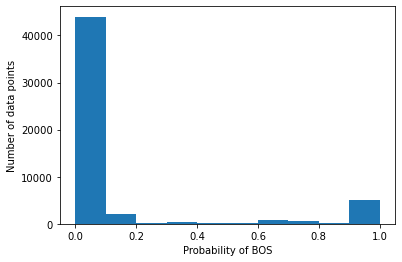

In [51]:
np.around(label_model.get_weights(), 2) 
import matplotlib.pyplot as plt


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of BOS")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, BOS])

### Weights of the rules 

In [52]:

np.around(label_model.get_weights(), 2) 

array([1.  , 0.69, 0.65, 1.  , 1.  , 0.73, 0.87, 0.61, 1.  , 0.4 , 0.98,
       1.  , 1.  , 0.91, 0.52])

### Number of labels for data points

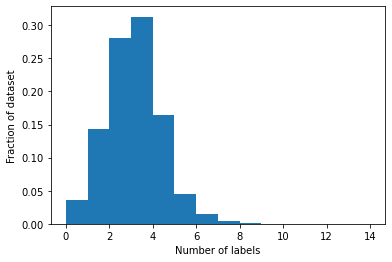

In [53]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## 8. Création de fichiers utiles sur la sortie du modèle génératif

1.Fichier pour entrainement/fine-tuning de ToNy
<br>
2.Fichier de visualisation des BOS de sortie du modèle génératif , comparaison avec le GOLD
<br>
3.Fichier de visualisation des virgules et leur lien avec les BOS
<br>
4.Fichier de visualisation des vrais tours VS tours détectés automatiquement 
<br>
5.Fichier segmentation snorkel sans ponctuation
<br>

### 1.Fichier pour entrainement/fine-tuning de ToNy

In [36]:
probs_train = label_model.predict_proba(L_train)

label=[]
for e in probs_train:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file_tony=open("file_train_tony_11032021.txt", "w")
i=0

for x in df_train.itertuples():
    if x.rank_turn==0:
        file_tony.write("\n")
    if label[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1
file_tony.close()


In [248]:
#création fichier 

file_tony=open("file_gold_dev_tony.txt", "w")
i=0

for x in df_dev.itertuples():
    if x.rank_turn==0:
        file_tony.write("\n")
    if Y_dev[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1

file_tony.close()

In [38]:
#création fichier 

file_tony=open("file_gold_test_tony.txt", "w")
i=0

for x in df_test.itertuples():
    if x.rank_turn==0:
        file_tony.write("\n")
    if Y_test[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1

file_tony.close()

### 2.Fichier de visualisation des BOS de sortie du modèle génératif , comparaison avec le GOLD

In [ ]:
# création d'un fichier de sortie joli pour vérifier qualitativement si ça marche bien 


label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("readable_bos_output_generative_model.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_turn==0 :
        if x.prob_period_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk---"+"\n"+"\n")

    if label[i]==1:
        liste_texte.append("|D|")
    if Y_dev[i]==1:
        liste_texte.append("|G|")      
    
    
    if x.prob_period_bef>0.5 or x.real_rank_turn==0:
        mot=str(mot).capitalize()
    
    if x.prob_period>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()
    

### 3.Fichier de visualisation des virgules et leur lien avec les BOS

In [ ]:
# visualisation des virgules 

label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("virgules_bos_19012021.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_turn==0 :
        if x.prob_period_bef<0.5 and i>0 and x.prob_comma_bef<0.3:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk---"+"\n"+"\n")

    if Y_dev[i]==1:
        liste_texte.append("|G|")      
    
    
    if x.prob_period_bef>0.5 or x.real_rank_turn==0:
        mot=str(mot).capitalize()
    
    if x.prob_period>0.5:
        mot=mot+"."

    if x.prob_comma>0.3:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()

### 4. Fichier de visualisation des vrais tours VS tours détectés automatiquement 

In [ ]:
# visualisation erreur d echangmenet de speaker 


label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("spk_change.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.rank_turn==0 :
        if x.prob_period_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk detected---"+"\n"+"\n")

    if x.real_rank_turn==0:
        liste_texte.append("|SPK|")
     
   
    if x.prob_period_bef>0.5 or x.real_rank_turn==0:
        mot=str(mot).capitalize()
    
    if x.prob_period>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()

In [39]:
# visualisation erreur d echangmenet de speaker 




file=open("spk_change_comparison_R1.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_turn==0 :
        if x.prob_period_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Real turn---"+"\n"+"\n")
        

    if x.rank_turn==0:
        liste_texte.append("|D_SPK|")
    
    #if label[i]==1:
        #liste_texte.append("|D_BOS|")
        
    
    
    if x.prob_period_bef>0.5 or x.real_rank_turn==0:
        mot=str(mot).capitalize()
    
    if x.prob_period>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))
print("bonjou")
file.close()

bonjou


### 5. Fichier segmentation snorkel sans ponctuation 

In [42]:
# train
probs_train = label_model.predict_proba(L_train)
label=[]
for e in probs_train:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)


df_train_bos=df_train.copy()

print(len(df_train_bos), len(label))    
    
df_train_bos["bos_snorkel"]=label

#df_train_bos.head()



53692 53692


In [43]:
list_name=['Linagora_P6', 'Linagora_C3',
'Linagora_P5', 'Linagora_R4', 'Linagora_R3', 'Linagora_C2', 'Linagora_P4']
for name_file in list_name:
    file=open("samir/"+name_file+".txt","w")
    df_r=df_train_bos[(df_train_bos["file"]==name_file)]
    #df_r.head()
    i=0
    text=[]
    for x in df_r.itertuples():
        if (x.bos_snorkel==1 or x.real_rank_turn==0) and i!=0:
            file.write("\n"+name_file+" "+" ".join(text))
            deb=x.beg_word
            text=[]

        text.append(x.word)
        i+=1

    file.close()

In [44]:
# test
probs_test = label_model.predict_proba(L_test)
label=[]
for e in probs_test:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)


df_test_bos=df_test.copy()

print(len(df_test_bos), len(label))    
    
df_test_bos["bos_snorkel"]=label


#df_train_bos.head()



8833 8833


In [45]:
list_name=['Linagora_P1', 'Linagora_C1']
for name_file in list_name:
    file=open("samir/"+name_file+".txt","w")
    df_r=df_test_bos[(df_test_bos["file"]==name_file)]

    i=0
    text=[]
    for x in df_r.itertuples():
        if (x.bos_snorkel==1 or x.real_rank_turn==0) and i!=0:
            file.write("\n"+name_file+" "+" ".join(text))
            deb=x.beg_word
            text=[]

        text.append(x.word)
        i+=1

    file.close()

In [46]:
# dev
probs_dev = label_model.predict_proba(L_dev)
label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)


df_dev_bos=df_dev.copy()

print(len(df_dev_bos), len(label))    
    
df_dev_bos["bos_snorkel"]=label




9752 9752


In [47]:
list_name=['Linagora_R1', 'Linagora_A1']
for name_file in list_name:
    file=open("samir/"+name_file+".txt","w")
    df_r=df_dev_bos[(df_dev_bos["file"]==name_file)]

    i=0
    text=[]
    for x in df_r.itertuples():
        if (x.bos_snorkel==1 or x.real_rank_turn==0) and i!=0:
            file.write("\n"+name_file+" "+" ".join(text))
            deb=x.beg_word
            text=[]

        text.append(x.word)
        i+=1

    file.close()

In [58]:
df_test_dev=pd.concat([df_dev_bos, df_test_bos])
#df_test_dev.head()

df_test_dev_samir=df_test_dev[["word","file", "gold", "bos_snorkel"]]
liste_name=['Linagora_R1', 'Linagora_A1','Linagora_P1', 'Linagora_C1']
for e in liste_name:
    df_r=df_test_dev_samir[df_test_dev_samir["file"]==e]
    df_r=df_r.rename(columns={'gold' : 'bos_gold'}) 
    df_r.to_csv(e+".csv", index=False)
#df_test_dev_samir.head()


In [59]:

df_train_samir=df_train_bos[["word","file","gold", "bos_snorkel"]]
liste_name=['Linagora_P6', 'Linagora_C3',
'Linagora_P5', 'Linagora_R4', 'Linagora_R3', 'Linagora_C2', 'Linagora_P4']
for e in liste_name:
    df_r=df_train_samir[df_train_samir["file"]==e]
    df_r=df_r.rename(columns={'gold' : 'bos_gold'}) 
    df_r.to_csv("samir_v2/"+e+".csv", index=False)
#df_test_dev_samir.head()

#### Création de fichier pour la démo Gautier

In [45]:
# RAP 4
probs_train = label_model.predict_proba(L_train)
label=[]
for e in probs_train:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)


df_train_bos=df_train.copy()

print(len(df_train_bos), len(label))    
    
df_train_bos["bos_snorkel"]=label

53692 53692


In [48]:
#df_train_bos.head()

In [64]:
#df_train_bos["bos_snorkel"]=label

df_train_bos.head()

file=open("rap4_actes_dialogues.txt","w")

df_r4=df_train_bos[(df_train_bos["file"]=="Linagora_R4")]

df_r4.head()
i=0
deb=float(df_r4.iat[0,2])
print(deb)
text=[]
for x in df_r4.itertuples():
    if x.bos_snorkel==1 and i!=0:
        
        file.write("\n"+"Linagora_R4 "+str(deb)+" "+str(x.beg_word)+" "+" ".join(text))
        deb=x.beg_word
        text=[]
        
    text.append(x.word)
    i+=1
        
file.close()


37.74


In [37]:
# RAP 4
probs_dev = label_model.predict_proba(L_dev)
label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)


df_dev_bos=df_dev.copy()

print(len(df_dev_bos), len(label))    
    
df_dev_bos["bos_snorkel"]=label

9752 9752


In [39]:

df_dev_bos.head()

file=open("rap1_actes_dialogues_VT.txt","w")

df_r1=df_dev_bos[(df_dev_bos["file"]=="Linagora_R1")]

df_r1.head()
i=0
deb=float(df_r1.iat[0,2])
print(deb)
text=[]
for x in df_r1.itertuples():
    if (x.gold==1 or x.real_rank_turn==0) and i!=0:
        
        file.write("\n"+"Linagora_R1 "+str(deb)+" "+str(x.beg_word)+" "+" ".join(text))
        deb=x.beg_word
        text=[]
        
    text.append(x.word)
    i+=1
        
file.close()


0.91


In [ ]:
file=open("real_truns_timestamp")

for x in df_dev.itertuples():
    if x.real_rank_turn==0:
        